In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import pickle
from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [98]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows=60000)

In [100]:
data.tail(3)

school_state teacher_prefix project_grade_category  \
59997           pa            mrs             grades_3_5   
59998           ca             ms             grades_3_5   
59999           va            mrs          grades_prek_2   

       teacher_number_of_previously_posted_projects  project_is_approved  \
59997                                             6                    1   
59998                                            38                    1   
59999                                            13                    1   

              clean_categories                   clean_subcategories  \
59997             math_science                           mathematics   
59998  math_science music_arts                mathematics visualarts   
59999             math_science  appliedsciences environmentalscience   

                                                   essay    price  
59997  my class consists 30 students reside pennsylva...    39.19  
59998  please help us bring technology classroom help...  1368.93  
59999  my students students come many different cultu...    63.97

In [101]:
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'], axis=1)
print(x.shape,y.shape)
x.tail(3)

(60000, 8) (60000,)


school_state teacher_prefix project_grade_category  \
59997           pa            mrs             grades_3_5   
59998           ca             ms             grades_3_5   
59999           va            mrs          grades_prek_2   

       teacher_number_of_previously_posted_projects         clean_categories  \
59997                                             6             math_science   
59998                                            38  math_science music_arts   
59999                                            13             math_science   

                        clean_subcategories  \
59997                           mathematics   
59998                mathematics visualarts   
59999  appliedsciences environmentalscience   

                                                   essay    price  
59997  my class consists 30 students reside pennsylva...    39.19  
59998  please help us bring technology classroom help...  1368.93  
59999  my students students come many different cultu...    63.97

In [102]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

In [103]:
x_train.tail(3)

school_state teacher_prefix project_grade_category  \
2133            il            mrs             grades_3_5   
16011           ny             ms             grades_6_8   
14045           oh             mr            grades_9_12   

       teacher_number_of_previously_posted_projects         clean_categories  \
2133                                              0             specialneeds   
16011                                             1  music_arts specialneeds   
14045                                             0            health_sports   

      clean_subcategories                                              essay  \
2133         specialneeds  everyone genius but judge fish ability climb t...   
16011  music specialneeds  like schools school future home diverse group ...   
14045          teamsports  our football team comprised 45 men proven work...   

         price  
2133    518.16  
16011   529.69  
14045  1139.95

In [104]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape,'\n')

print('% of train data points',len(x_train)/(len(x_train)+ len(x_test))*100)
print('% of test data points',len(x_test)/(len(x_train)+ len(x_test))*100)

(40200, 8) (40200,)
(19800, 8) (19800,) 

% of train data points 67.0
% of test data points 33.0


In [105]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))
x_train_tfidf_vect_essays = vectorizer.fit_transform(x_train['essay'].values)
x_test_tfidf_vect_essays = vectorizer.transform(x_test['essay'].values)

print(x_train_tfidf_vect_essays.shape,y_train.shape)
print(x_test_tfidf_vect_essays.shape,y_test.shape)
# print(vectorizer.get_feature_names())

(40200, 133691) (40200,)
(19800, 133691) (19800,)


In [106]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'].values)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [107]:

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [108]:

tfidf_w2v_train_vectors = []; 
for sentence in tqdm(x_train['essay'].values): 
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
          
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train_vectors.append(vector)

print(len(tfidf_w2v_train_vectors))
print(len(tfidf_w2v_train_vectors[0]))

100%|██████████| 40200/40200 [04:29<00:00, 149.16it/s]

40200
300


In [109]:

tfidf_w2v_test_vectors = []; 
for sentence in tqdm(x_test['essay'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test_vectors.append(vector)

print(len(tfidf_w2v_test_vectors))
print(len(tfidf_w2v_test_vectors[0]))

100%|██████████| 19800/19800 [02:12<00:00, 149.03it/s]

19800
300


Sentiment score of project essays

In [110]:

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_score_train_positive=np.array([])
sentiment_score_train_negative=np.array([])
sentiment_score_train_neutral=np.array([])
sentiment_score_train_compound=np.array([])

sid = SentimentIntensityAnalyzer()

for essay in tqdm(x_train['essay']):
    ss_tr = sid.polarity_scores(essay)
    sentiment_score_train_positive=np.append(sentiment_score_train_positive,ss_tr['pos'])
    sentiment_score_train_negative=np.append(sentiment_score_train_negative,ss_tr['neg'])
    sentiment_score_train_neutral=np.append(sentiment_score_train_neutral,ss_tr['neu'])
    sentiment_score_train_compound=np.append(sentiment_score_train_compound,ss_tr['compound'])

100%|██████████| 40200/40200 [04:04<00:00, 164.44it/s]


In [111]:
sentiment_score_train_positive = np.reshape(sentiment_score_train_positive,(len(sentiment_score_train_positive),1))
sentiment_score_train_negative = np.reshape(sentiment_score_train_negative,(len(sentiment_score_train_negative),1))
sentiment_score_train_neutral = np.reshape(sentiment_score_train_neutral,(len(sentiment_score_train_neutral),1))
sentiment_score_train_compound = np.reshape(sentiment_score_train_compound,(len(sentiment_score_train_compound),1))

In [112]:
# Test data essays
sentiment_score_test_positive=np.array([])
sentiment_score_test_negative=np.array([])
sentiment_score_test_neutral=np.array([])
sentiment_score_test_compound=np.array([])

for essay in tqdm(x_test['essay']):
    ss_te = sid.polarity_scores(essay)
    sentiment_score_test_positive=np.append(sentiment_score_test_positive,ss_te['pos'])
    sentiment_score_test_negative=np.append(sentiment_score_test_negative,ss_te['neg'])
    sentiment_score_test_neutral=np.append(sentiment_score_test_neutral,ss_te['neu'])
    sentiment_score_test_compound=np.append(sentiment_score_test_compound,ss_te['compound'])

100%|██████████| 19800/19800 [01:58<00:00, 167.06it/s]


In [113]:
sentiment_score_test_positive = np.reshape(sentiment_score_test_positive,(len(sentiment_score_test_positive),1))
sentiment_score_test_negative = np.reshape(sentiment_score_test_negative,(len(sentiment_score_test_negative),1))
sentiment_score_test_neutral = np.reshape(sentiment_score_test_neutral,(len(sentiment_score_test_neutral),1))
sentiment_score_test_compound = np.reshape(sentiment_score_test_compound,(len(sentiment_score_test_compound),1))

<b>Encoding Categorical Features</b>

Encoding school_state feature

In [114]:
vectorizer = CountVectorizer()
x_train_school_state_encoded = vectorizer.fit_transform(x_train['school_state'].values)
x_test_school_state_encoded = vectorizer.transform(x_test['school_state'].values)

print(x_train_school_state_encoded.shape,y_train.shape)
print(x_test_school_state_encoded.shape,y_test.shape)
print(vectorizer.get_feature_names())

(40200, 51) (40200,)
(19800, 51) (19800,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


Encoding teacher_prefix feature

In [115]:
vectorizer = CountVectorizer()
x_train_teacher_prefix_encoded = vectorizer.fit_transform(x_train['teacher_prefix'].values)
x_test_teacher_prefix_encoded = vectorizer.transform(x_test['teacher_prefix'].values)

print(x_train_teacher_prefix_encoded.shape,y_train.shape)
print(x_test_teacher_prefix_encoded.shape,y_test.shape)
print(vectorizer.get_feature_names())

(40200, 5) (40200,)
(19800, 5) (19800,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


Encoding project_grade_category feature

In [116]:
vectorizer = CountVectorizer()
x_train_grade_encoded = vectorizer.fit_transform(x_train['project_grade_category'].values)
x_test_grade_encoded = vectorizer.transform(x_test['project_grade_category'].values)

print(x_train_grade_encoded.shape,y_train.shape)
print(x_test_grade_encoded.shape,y_test.shape)
print(vectorizer.get_feature_names())

(40200, 4) (40200,)
(19800, 4) (19800,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


Encoding clean_categories feature

In [117]:
vectorizer = CountVectorizer()
x_train_categories_encoded = vectorizer.fit_transform(x_train['clean_categories'].values)
x_test_categories_encoded = vectorizer.transform(x_test['clean_categories'].values)

print(x_train_categories_encoded.shape,y_train.shape)
print(x_test_categories_encoded.shape,y_test.shape)
print(vectorizer.get_feature_names())

(40200, 9) (40200,)
(19800, 9) (19800,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


Encoding clean_subcategories feature

In [118]:
vectorizer = CountVectorizer()
x_train_subcategories_encoded = vectorizer.fit_transform(x_train['clean_subcategories'].values)
x_test_subcategories_encoded = vectorizer.transform(x_test['clean_subcategories'].values)

print(x_train_subcategories_encoded.shape,y_train.shape)
print(x_test_subcategories_encoded.shape,y_test.shape)
print(vectorizer.get_feature_names())

(40200, 30) (40200,)
(19800, 30) (19800,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


<b>Encoding Numerical features</b>

In [120]:
x_train_price=x_train['price'].values.reshape(x_train['price'].shape[0],1)
x_train_previous_projects=x_train['teacher_number_of_previously_posted_projects'].values.reshape(x_train['teacher_number_of_previously_posted_projects'].shape[0],1)

x_test_price=x_test['price'].values.reshape(x_test['price'].shape[0],1)
x_test_previous_projects=x_test['teacher_number_of_previously_posted_projects'].values.reshape(x_test['teacher_number_of_previously_posted_projects'].shape[0],1)

In [121]:
from scipy.sparse import hstack
x_train_tfidf_encoded = hstack((x_train_tfidf_vect_essays,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_grade_encoded 
                        ,x_train_categories_encoded,x_train_subcategories_encoded,x_train_previous_projects
                        ,x_train_price,sentiment_score_train_positive,sentiment_score_train_negative
                        ,sentiment_score_train_neutral,sentiment_score_train_compound)).tocsr()

x_test_tfidf_encoded = hstack((x_test_tfidf_vect_essays,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_grade_encoded 
                       ,x_test_categories_encoded,x_test_subcategories_encoded,x_test_previous_projects
                       ,x_test_price,sentiment_score_test_positive,sentiment_score_test_negative
                        ,sentiment_score_test_neutral,sentiment_score_test_compound)).tocsr() 

In [122]:
print(x_train_tfidf_encoded.shape,y_train.shape)
print(x_test_tfidf_encoded.shape,y_test.shape)

(40200, 133796) (40200,)
(19800, 133796) (19800,)


In [123]:
x_train_tfidf_w2v_encoded = hstack((tfidf_w2v_train_vectors,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_grade_encoded 
                        ,x_train_categories_encoded,x_train_subcategories_encoded,x_train_previous_projects
                        ,x_train_price,sentiment_score_train_positive,sentiment_score_train_negative
                        ,sentiment_score_train_neutral,sentiment_score_train_compound)).tocsr()

x_test_tfidf_w2v_encoded = hstack((tfidf_w2v_test_vectors,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_grade_encoded 
                           ,x_test_categories_encoded,x_test_subcategories_encoded,x_test_previous_projects
                           ,x_test_price,sentiment_score_test_positive,sentiment_score_test_negative
                           ,sentiment_score_test_neutral,sentiment_score_test_compound)).tocsr() 

In [124]:
print(x_train_tfidf_w2v_encoded.shape,y_train.shape)
print(x_test_tfidf_w2v_encoded.shape,y_test.shape)

(40200, 405) (40200,)
(19800, 405) (19800,)


 TfIdf 

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_clf_tfidf = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf1 = GridSearchCV(dt_clf_tfidf, parameters,cv=5, scoring='roc_auc',n_jobs=-1,return_train_score=True,verbose=10)
clf1.fit(x_train_tfidf_encoded,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:  8.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed: 10.9min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 11.6min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [126]:
print('best params : ',clf1.best_params_)
print('best_score : ',clf1.best_score_)
print('best_estimator_ : ',clf1.best_estimator_)

best params :  {'max_depth': 10, 'min_samples_split': 500}
best_score :  0.6364469788655337
best_estimator_ :  DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)


In [127]:
results = pd.DataFrame.from_dict(clf1.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
max_depth =  results['param_max_depth']
min_samples_split = results['param_min_samples_split']

print(results.columns)
results.head(5)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.487828      0.399916         0.112919        0.022386   
1       6.919102      0.911031         0.166031        0.077821   
2       6.749062      0.624258         0.131794        0.071497   
3       6.213904      0.298747         0.100947        0.002286   
4      25.761374      0.953930         0.108174        0.009070   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.546935   
1   {'max_depth': 1, 'min_samples_split': 10}           0.546935   
2  {'max_depth': 1, 'min_samples_split': 100}           0.546935   
3  {'max_depth': 1, 'min_samples_split': 500}           0.546935   
4    {'max_depth': 5, 'min_samples_split': 5}           0.616577   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.546766           0.550056  ...         0.547341        0.001881   
1           0.546766           0.550056  ...         0.547341        0.001881   
2           0.546766           0.550056  ...         0.547341        0.001881   
3           0.546766           0.550056  ...         0.547341        0.001881   
4           0.628396           0.633886  ...         0.625394        0.007572   

   rank_test_score  split0_train_score  split1_train_score  \
0               13            0.545286            0.549034   
1               13            0.545286            0.549034   
2               13            0.545286            0.549034   
3               13            0.545286            0.549034   
4                6            0.651614            0.655718   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.548127            0.548597            0.549618   
1            0.548127            0.548597            0.549618   
2            0.548127            0.548597            0.549618   
3            0.548127            0.548597            0.549618   
4            0.652347            0.657479            0.652127   

   mean_train_score  std_train_score  
0          0.548132         0.001506  
1          0.548132         0.001506  
2          0.548132         0.001506  
3          0.548132         0.001506  
4          0.653857         0.002319  

[5 rows x 22 columns]

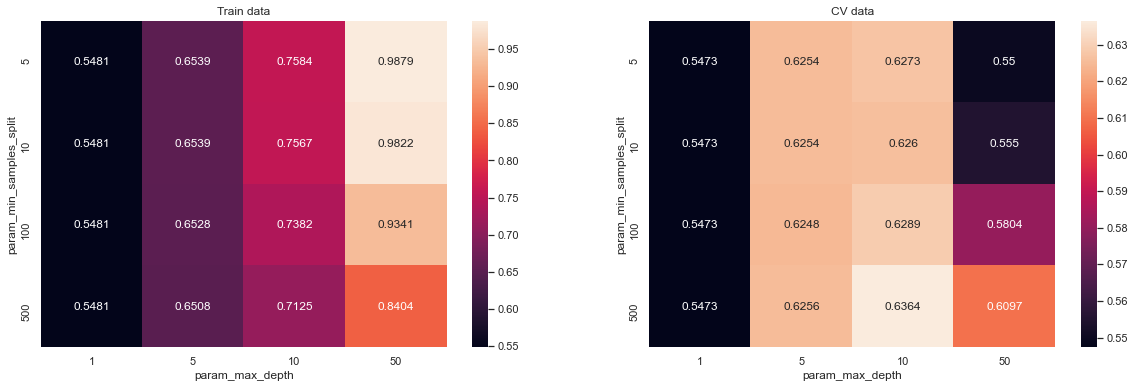

In [128]:

import seaborn as sns;
pvt1 = pd.pivot_table(pd.DataFrame(clf1.cv_results_),
    values='mean_train_score', index='param_min_samples_split', columns='param_max_depth')
pvt2 = pd.pivot_table(pd.DataFrame(clf1.cv_results_),
    values='mean_test_score', index='param_min_samples_split', columns='param_max_depth')

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(pvt1, annot=True, fmt='.4g',ax=ax[0])
sns.heatmap(pvt2, annot=True, fmt='.4g',ax=ax[1])

ax[0].set_title('Train data')
ax[1].set_title('CV data')

plt.show()

In [129]:
def batch_predict(clf, data):


    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
   
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

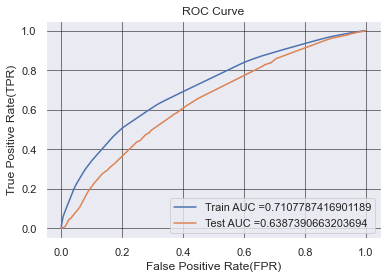

In [130]:

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

best_depth_tfidf=10
best_min_samples_split_tfidf=500
clf_tfidf1 = DecisionTreeClassifier(max_depth=best_depth_tfidf, min_samples_split=best_min_samples_split_tfidf,class_weight='balanced')
clf_tfidf1.fit(x_train_tfidf_encoded, y_train)


y_train_pred = batch_predict(clf_tfidf1, x_train_tfidf_encoded)    
y_test_pred = batch_predict(clf_tfidf1, x_test_tfidf_encoded)   


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
auc_tfidf=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [131]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [132]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4289772628362908 for threshold 0.477
Train confusion matrix
[[ 4366  2022]
 [12590 21222]]
Test confusion matrix
[[1916 1231]
 [6676 9977]]


Text(0.5, 1.0, 'Train data confusion matrix')

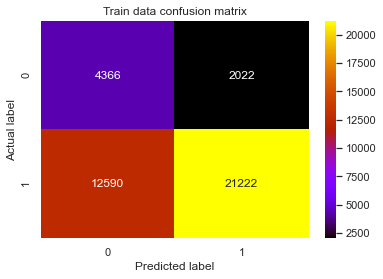

In [133]:

import matplotlib.pyplot as plt     
import seaborn as sns;sns.set()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Train data confusion matrix')

Text(0.5, 1.0, 'Test data confusion matrix')

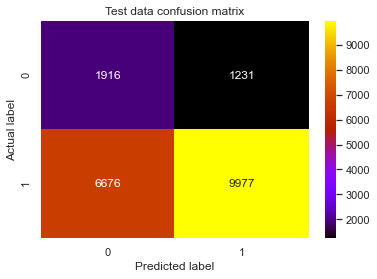

In [134]:

sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Test data confusion matrix')

In [136]:
fp=[]
for i in range(len(y_test)):
    if y_test[i]==0 and y_test_pred[i]>=best_t:
        fp.append(i)
len(fp)        

1231

In [137]:
fp_pts_essay = x_test['essay'].iloc[fp]

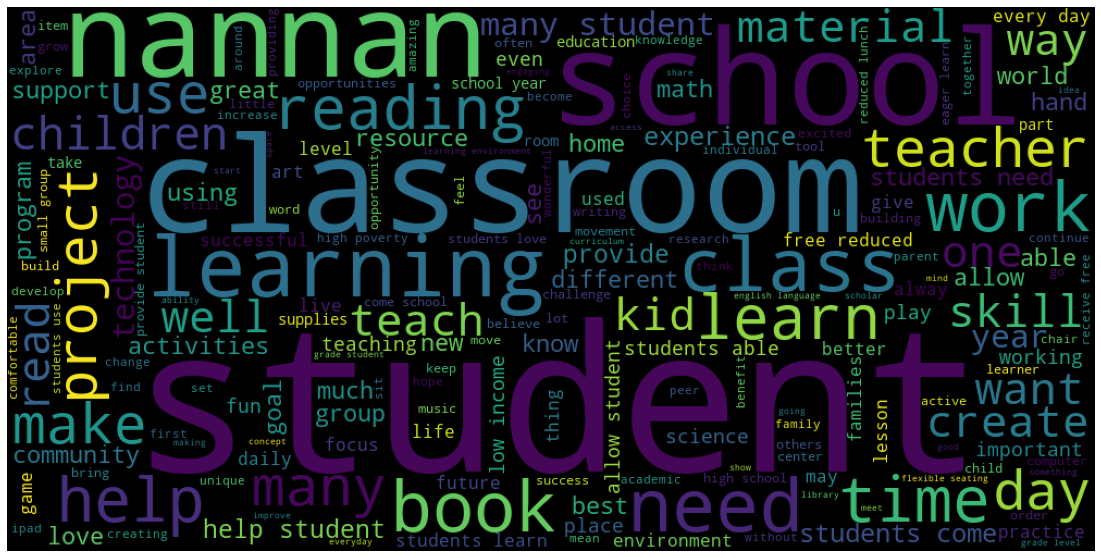

In [138]:

from wordcloud import STOPWORDS
from wordcloud import WordCloud

stopwords = set(STOPWORDS)
words_string=(" ").join(fp_pts_essay)
wordcloud = WordCloud(width = 1000, height = 500,  stopwords = stopwords).generate(words_string)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [139]:

fp_pts_price = x_test['price'].iloc[fp]

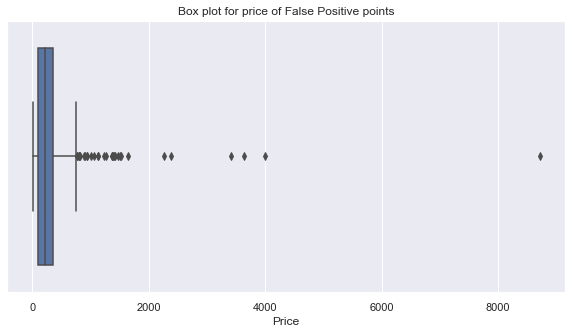

In [140]:
plt.figure(figsize=(10,5))
sns.boxplot(fp_pts_price)
plt.title("Box plot for price of False Positive points")
plt.xlabel("Price")
plt.show()

In [141]:

fp_pts_prevproj = x_test['teacher_number_of_previously_posted_projects'].iloc[fp]

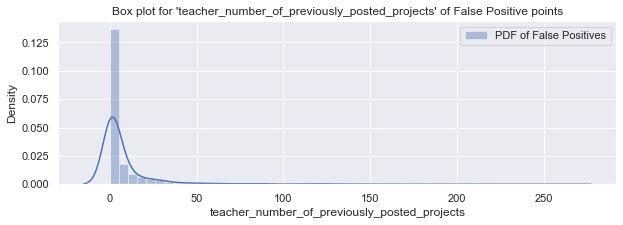

In [142]:
plt.figure(figsize=(10,3))
sns.distplot(fp_pts_prevproj,label="PDF of False Positives")
plt.title("Box plot for 'teacher_number_of_previously_posted_projects' of False Positive points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.legend()
plt.show()

TfIdf W2V

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_clf_tfidf = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf2 = GridSearchCV(dt_clf_tfidf, parameters,cv=5, scoring='roc_auc',n_jobs=-1,return_train_score=True,verbose=10)
clf2.fit(x_train_tfidf_w2v_encoded,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:  7.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed:  8.3min remaining:   33.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.4min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [144]:
print('best params : ',clf2.best_params_)
print('best_score : ',clf2.best_score_)
print('best_estimator_ : ',clf2.best_estimator_)

best params :  {'max_depth': 5, 'min_samples_split': 500}
best_score :  0.6229886285933272
best_estimator_ :  DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=500)


In [145]:
results = pd.DataFrame.from_dict(clf2.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
max_depth =  results['param_max_depth']
min_samples_split = results['param_min_samples_split']

print(results.columns)
results.head(5)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.902279      0.053335         0.088329        0.026997   
1       6.853960      0.284812         0.095140        0.015725   
2       6.304839      0.189328         0.098105        0.005804   
3       6.379810      0.232986         0.105336        0.009977   
4      31.194599      0.919267         0.087219        0.011313   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.546935   
1   {'max_depth': 1, 'min_samples_split': 10}           0.546935   
2  {'max_depth': 1, 'min_samples_split': 100}           0.546935   
3  {'max_depth': 1, 'min_samples_split': 500}           0.546935   
4    {'max_depth': 5, 'min_samples_split': 5}           0.633082   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.546766           0.550056  ...         0.547341        0.001881   
1           0.546766           0.550056  ...         0.547341        0.001881   
2           0.546766           0.550056  ...         0.547341        0.001881   
3           0.546766           0.550056  ...         0.547341        0.001881   
4           0.614785           0.630975  ...         0.622620        0.007762   

   rank_test_score  split0_train_score  split1_train_score  \
0               11            0.545286            0.549034   
1               11            0.545286            0.549034   
2               11            0.545286            0.549034   
3               11            0.545286            0.549034   
4                2            0.665008            0.665406   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.548127            0.548597            0.549618   
1            0.548127            0.548597            0.549618   
2            0.548127            0.548597            0.549618   
3            0.548127            0.548597            0.549618   
4            0.665381            0.669228            0.666181   

   mean_train_score  std_train_score  
0          0.548132         0.001506  
1          0.548132         0.001506  
2          0.548132         0.001506  
3          0.548132         0.001506  
4          0.666241         0.001542  

[5 rows x 22 columns]

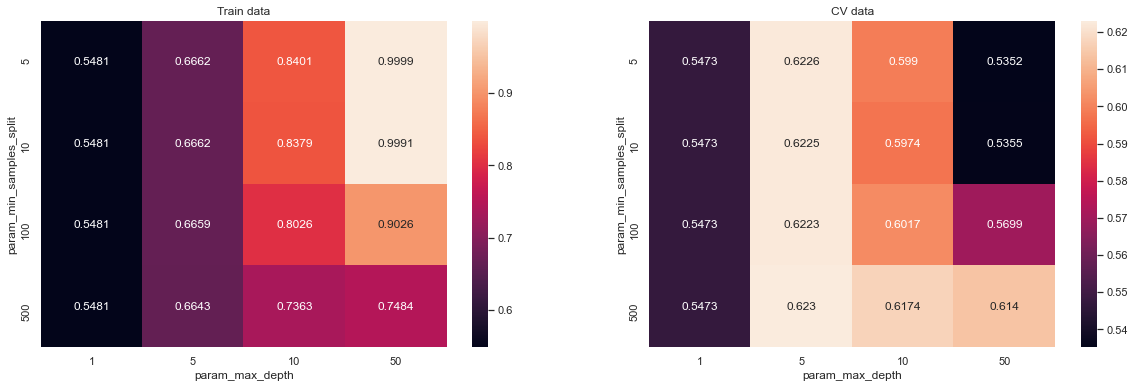

In [146]:

import seaborn as sns;
pvt1 = pd.pivot_table(pd.DataFrame(clf2.cv_results_),
    values='mean_train_score', index='param_min_samples_split', columns='param_max_depth')
pvt2 = pd.pivot_table(pd.DataFrame(clf2.cv_results_),
    values='mean_test_score', index='param_min_samples_split', columns='param_max_depth')

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(pvt1, annot=True, fmt='.4g',ax=ax[0])
sns.heatmap(pvt2, annot=True, fmt='.4g',ax=ax[1])

ax[0].set_title('Train data')
ax[1].set_title('CV data')

plt.show()

In [147]:
def batch_predict(clf, data):


    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

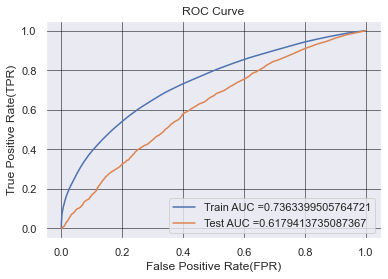

In [148]:

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

best_depth_tfidf_W2V=10
best_min_samples_split_tfidf_W2V=500
clf_tfidf2 = DecisionTreeClassifier(max_depth=best_depth_tfidf_W2V, min_samples_split=best_min_samples_split_tfidf_W2V,class_weight='balanced')
clf_tfidf2.fit(x_train_tfidf_w2v_encoded, y_train)


y_train_pred = batch_predict(clf_tfidf2, x_train_tfidf_w2v_encoded)    
y_test_pred = batch_predict(clf_tfidf2, x_test_tfidf_w2v_encoded)   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
auc_tfidf_W2V=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [149]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [150]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.45474523259889055 for threshold 0.49
Train confusion matrix
[[ 4477  1911]
 [11873 21939]]
Test confusion matrix
[[ 1763  1384]
 [ 6385 10268]]


Text(0.5, 1.0, 'Train data confusion matrix')

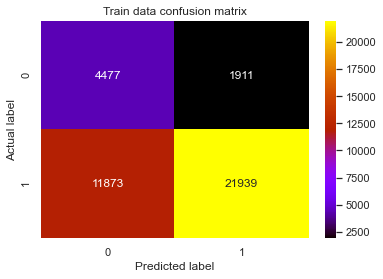

In [151]:

import matplotlib.pyplot as plt     
import seaborn as sns;sns.set()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Train data confusion matrix')

Text(0.5, 1.0, 'Test data confusion matrix')

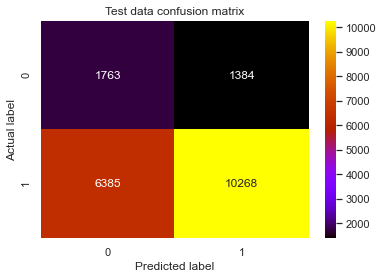

In [152]:


sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Test data confusion matrix')

In [154]:
fp=[]
for i in range(len(y_test)):
    if y_test[i]==0 and y_test_pred[i]>=best_t:
        fp.append(i)
len(fp)       

1384

In [155]:
fp_pts_essay = x_test['essay'].iloc[fp]

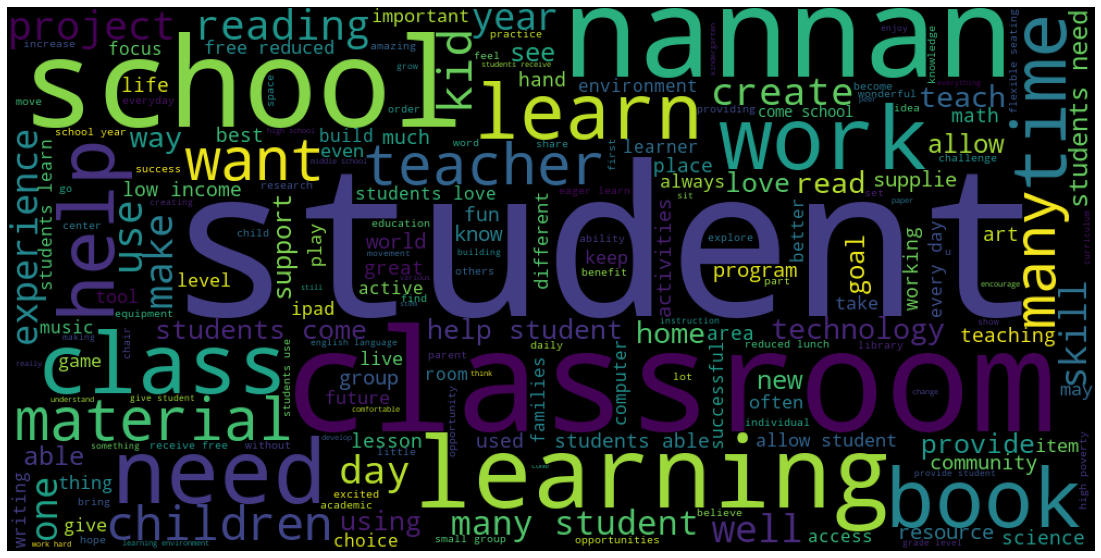

In [61]:

from wordcloud import STOPWORDS
from wordcloud import WordCloud

stopwords = set(STOPWORDS)
words_string=(" ").join(fp_pts_essay)
wordcloud = WordCloud(width = 1000, height = 500,  stopwords = stopwords).generate(words_string)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Box plot with the price of false positive data points

In [62]:

fp_pts_price = x_test['price'].iloc[fp]

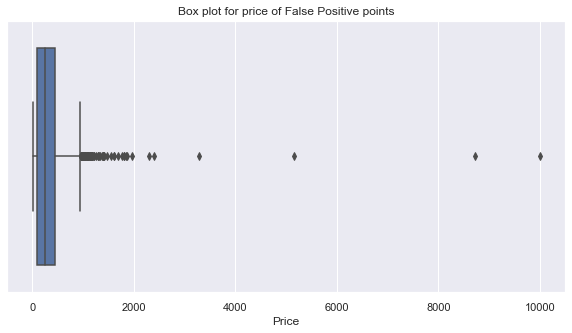

In [63]:
plt.figure(figsize=(10,5))
sns.boxplot(fp_pts_price)
plt.title("Box plot for price of False Positive points")
plt.xlabel("Price")
plt.show()

PDF plot with the teacher_number_of_previously_posted_projects of false positive data points

In [64]:

fp_pts_prevproj = x_test['teacher_number_of_previously_posted_projects'].iloc[fp]

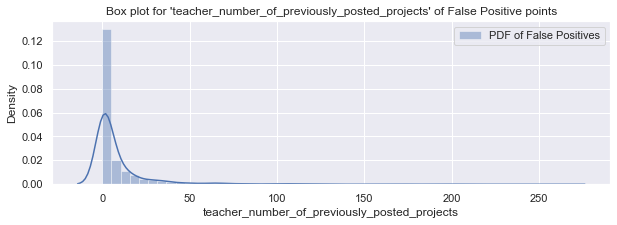

In [65]:
plt.figure(figsize=(10,3))
sns.distplot(fp_pts_prevproj,label="PDF of False Positives")
plt.title("Box plot for 'teacher_number_of_previously_posted_projects' of False Positive points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.legend()
plt.show()

In [66]:
from sklearn.tree import DecisionTreeClassifier
clf_tfidf_fi = DecisionTreeClassifier(max_depth=None, min_samples_split=best_min_samples_split_tfidf,class_weight='balanced')
clf_tfidf_fi.fit(x_train_tfidf_encoded, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_split=500)

In [67]:
feature_values = clf_tfidf_fi.feature_importances_

In [68]:
feature_values.shape

(157302,)

In [69]:

feature_indices = np.where(feature_values!=0) 

In [70]:
len(feature_indices[0])

736

In [71]:

x_train_tfidf_encoded_imp_features = x_train_tfidf_encoded[:,feature_indices[0]]
x_test_tfidf_encoded_imp_features = x_test_tfidf_encoded[:,feature_indices[0]]

In [72]:
x_train_tfidf_encoded_imp_features

<46900x736 sparse matrix of type '<class 'numpy.float64'>'
	with 1797539 stored elements in Compressed Sparse Row format>

In [73]:
x_test_tfidf_encoded_imp_features

<23100x736 sparse matrix of type '<class 'numpy.float64'>'
	with 886817 stored elements in Compressed Sparse Row format>

In [74]:
#Using decision trees classifier
dt_clf_tfidf = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf3 = GridSearchCV(dt_clf_tfidf, parameters,cv=10, scoring='roc_auc',n_jobs=-1,return_train_score=True,verbose=10)
clf3.fit(x_train_tfidf_encoded_imp_features,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 out of 160 | elapsed:  4.6min remaining:   10.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.8min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [75]:
print('best params : ',clf3.best_params_)
print('best_score : ',clf3.best_score_)
print('best_estimator_ : ',clf3.best_estimator_)

best params :  {'max_depth': 10, 'min_samples_split': 500}
best_score :  0.6544537131548746
best_estimator_ :  DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)


In [77]:
results = pd.DataFrame.from_dict(clf3.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])
print(results.columns)
results.head(5)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.256358      0.021550         0.017189        0.004695   
1       1.268162      0.106343         0.014096        0.004700   
2       1.206850      0.197809         0.015472        0.008143   
3       1.052540      0.061774         0.014765        0.009420   
4       4.821816      0.501408         0.017354        0.007031   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.552484   
1   {'max_depth': 1, 'min_samples_split': 10}           0.552484   
2  {'max_depth': 1, 'min_samples_split': 100}           0.552484   
3  {'max_depth': 1, 'min_samples_split': 500}           0.552484   
4    {'max_depth': 5, 'min_samples_split': 5}           0.630873   

   split1_test_score  split2_test_score  ...  split2_train_score  \
0           0.547680           0.549977  ...             0.55253   
1           0.547680           0.549977  ...             0.55253   
2           0.547680           0.549977  ...             0.55253   
3           0.547680           0.549977  ...             0.55253   
4           0.627468           0.620799  ...             0.65058   

   split3_train_score  split4_train_score  split5_train_score  \
0            0.552236            0.552841            0.552201   
1            0.552236            0.552841            0.552201   
2            0.552236            0.552841            0.552201   
3            0.552236            0.552841            0.552201   
4            0.654265            0.648486            0.648777   

   split6_train_score  split7_train_score  split8_train_score  \
0            0.552577            0.552141            0.552032   
1            0.552577            0.552141            0.552032   
2            0.552577            0.552141            0.552032   
3            0.552577            0.552141            0.552032   
4            0.651048            0.654747            0.651483   

   split9_train_score  mean_train_score  std_train_score  
0            0.551273          0.552287         0.000427  
1            0.551273          0.552287         0.000427  
2            0.551273          0.552287         0.000427  
3            0.551273          0.552287         0.000427  
4            0.651672          0.651929         0.002199  

[5 rows x 32 columns]

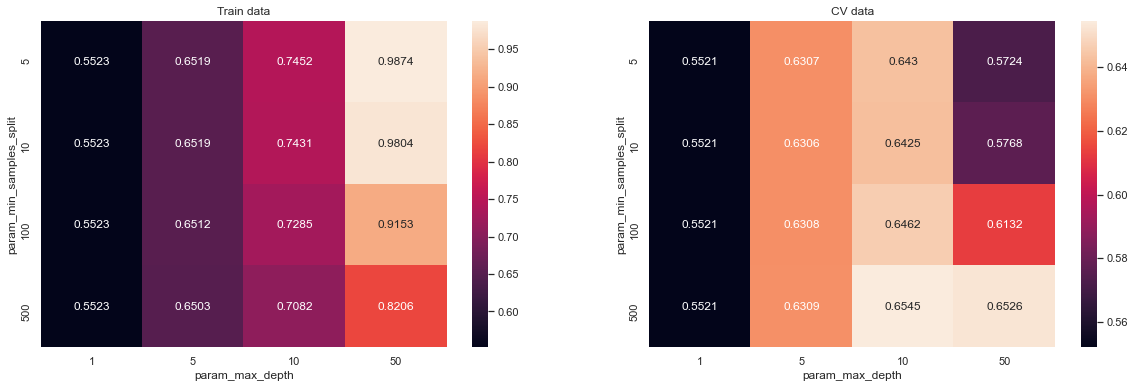

In [78]:

import seaborn as sns;
pvt1 = pd.pivot_table(pd.DataFrame(clf3.cv_results_),
    values='mean_train_score', index='param_min_samples_split', columns='param_max_depth')
pvt2 = pd.pivot_table(pd.DataFrame(clf3.cv_results_),
    values='mean_test_score', index='param_min_samples_split', columns='param_max_depth')

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(pvt1, annot=True, fmt='.4g',ax=ax[0])
sns.heatmap(pvt2, annot=True, fmt='.4g',ax=ax[1])

ax[0].set_title('Train data')
ax[1].set_title('CV data')

plt.show()

In [79]:
def batch_predict(clf, data):


    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

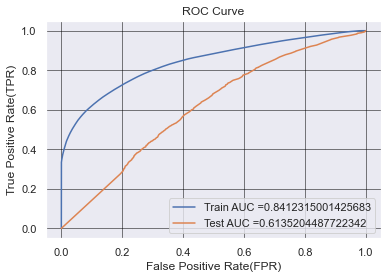

In [80]:

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

best_depth_fi=50
best_min_samples_split_fi=500
clf_tfidf3 = DecisionTreeClassifier(max_depth=best_depth_fi, min_samples_split=best_min_samples_split_fi,class_weight='balanced')
clf_tfidf3.fit(x_train_tfidf_encoded_imp_features, y_train)


y_train_pred = batch_predict(clf_tfidf3, x_train_tfidf_encoded_imp_features)    
y_test_pred = batch_predict(clf_tfidf3, x_test_tfidf_encoded_imp_features)   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
auc_dt_fi=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [81]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
 
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [82]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.580601686293104 for threshold 0.479
Train confusion matrix
[[ 5882  1431]
 [11011 28576]]
Test confusion matrix
[[ 1864  1738]
 [ 6642 12856]]


Text(0.5, 1.0, 'Train data confusion matrix')

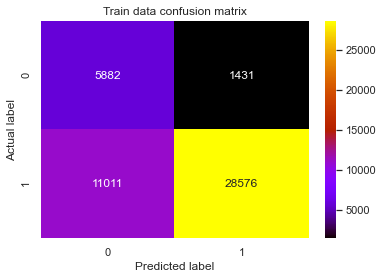

In [83]:

import matplotlib.pyplot as plt     
import seaborn as sns;sns.set()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Train data confusion matrix')

Text(0.5, 1.0, 'Test data confusion matrix')

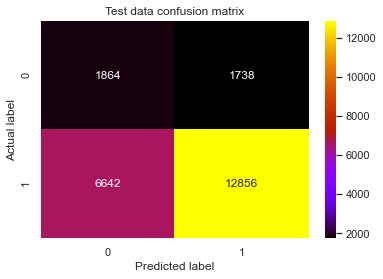

In [84]:

sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Test data confusion matrix')

 Logistic Regression

In [85]:

from sklearn.linear_model import LogisticRegression
lr_clf_tfidf = LogisticRegression(penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.5,0.25,0.05,1,5,10,50,10,100,1000,10000]}
clf_lr = GridSearchCV(lr_clf_tfidf, parameters,cv=10, scoring='roc_auc',n_jobs=-1,return_train_score=True,verbose=10)
clf_lr.fit(x_train_tfidf_encoded_imp_features,y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   55.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   57.2s finished


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.25, 0.05, 1, 5,
                               10, 50, 10, 100, 1000, 10000]},
             return_train_score=True, scoring='roc_auc', verbose=10)

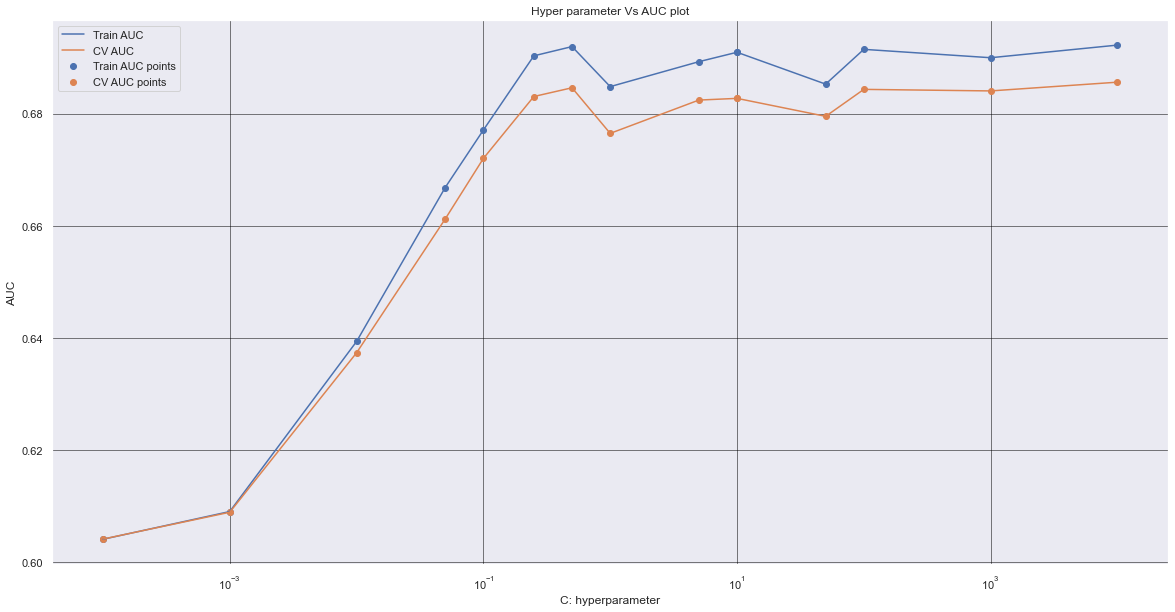

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       2.139175      0.298174         0.014794        0.010581  0.0001   
1       2.247498      0.482060         0.013759        0.005096   0.001   
2       3.162674      0.474935         0.012924        0.009600    0.01   
6       3.944782      0.877892         0.012574        0.004671    0.05   
3       4.675389      0.659343         0.014525        0.005167     0.1   

          params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 0.0001}           0.612942           0.609614           0.596469   
1   {'C': 0.001}           0.618148           0.614481           0.601890   
2    {'C': 0.01}           0.648661           0.638900           0.629941   
6    {'C': 0.05}           0.666453           0.653437           0.665840   
3     {'C': 0.1}           0.665512           0.670997           0.662478   

   split3_test_score  ...  split2_train_score  split3_train_score  \
0           0.601585  ...            0.605037            0.604300   
1           0.605725  ...            0.610333            0.609734   
2           0.630548  ...            0.641478            0.640519   
6           0.661898  ...            0.682563            0.678963   
3           0.672894  ...            0.673779            0.690632   

   split4_train_score  split5_train_score  split6_train_score  \
0            0.604560            0.603850            0.605453   
1            0.609868            0.609020            0.611082   
2            0.639534            0.639803            0.640992   
6            0.641465            0.678660            0.663426   
3            0.692199            0.663796            0.686992   

   split7_train_score  split8_train_score  split9_train_score  \
0            0.605315            0.603369            0.601944   
1            0.610698            0.608646            0.603313   
2            0.641066            0.631175            0.639155   
6            0.676938            0.661207            0.661386   
3            0.665190            0.687726            0.663510   

   mean_train_score  std_train_score  
0          0.604072         0.001028  
1          0.609019         0.002071  
2          0.639349         0.002816  
6          0.666814         0.011853  
3          0.677066         0.011763  

[5 rows x 31 columns]

In [87]:
results = pd.DataFrame.from_dict(clf_lr.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
c =  results['param_C']

plt.figure(figsize=(20,10))
plt.plot(c, train_auc, label='Train AUC')
plt.plot(c, cv_auc, label='CV AUC')
plt.scatter(c, train_auc, label='Train AUC points')
plt.scatter(c, cv_auc, label='CV AUC points')
plt.xscale('log')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

results.head()

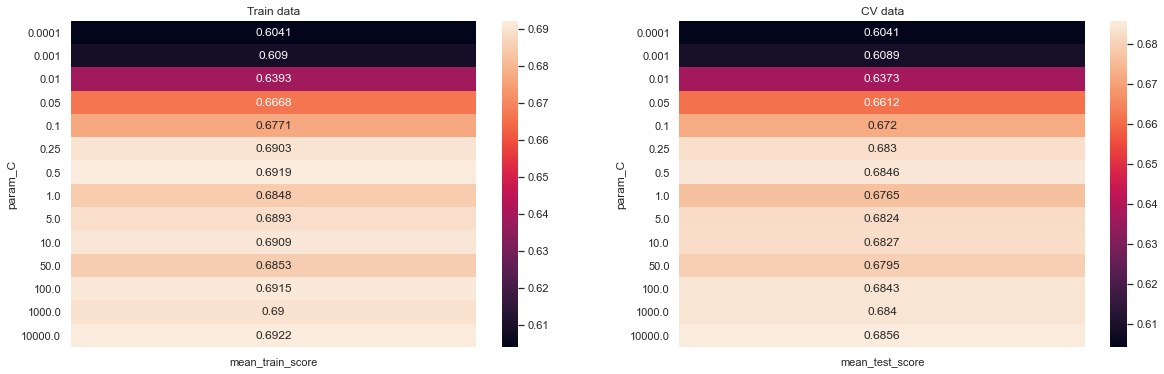

In [88]:

import seaborn as sns;
pvt1 = pd.pivot_table(pd.DataFrame(clf_lr.cv_results_),
    values='mean_train_score', index='param_C')
pvt2 = pd.pivot_table(pd.DataFrame(clf_lr.cv_results_),
    values='mean_test_score', index='param_C')

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(pvt1, annot=True, fmt='.4g',ax=ax[0])
sns.heatmap(pvt2, annot=True, fmt='.4g',ax=ax[1])

ax[0].set_title('Train data')
ax[1].set_title('CV data')

plt.show()

In [89]:
def batch_predict(clf, data):
  
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

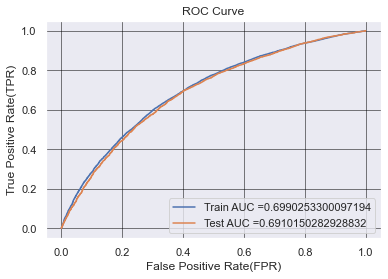

In [92]:

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

best_c=0.5
clf_tfidf = LogisticRegression(C=best_c,penalty='l2',class_weight='balanced')
clf_tfidf.fit(x_train_tfidf_encoded_imp_features, y_train)


y_train_pred = batch_predict(clf_tfidf, x_train_tfidf_encoded_imp_features)    
y_test_pred = batch_predict(clf_tfidf, x_test_tfidf_encoded_imp_features)   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
auc_tfidf_lr=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [93]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [94]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4221336150395249 for threshold 0.508
Train confusion matrix
[[ 4893  2420]
 [14611 24976]]
Test confusion matrix
[[ 2369  1233]
 [ 7221 12277]]


Text(0.5, 1.0, 'Train data confusion matrix')

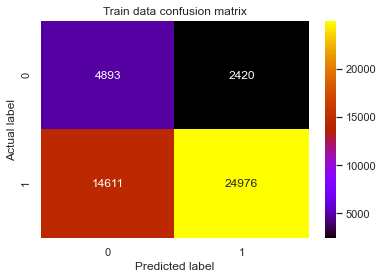

In [95]:

import matplotlib.pyplot as plt     
import seaborn as sns;sns.set()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Train data confusion matrix')

Text(0.5, 1.0, 'Test data confusion matrix')

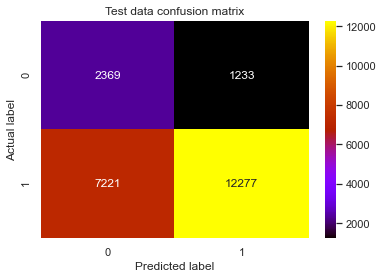

In [96]:

sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True,fmt="d",cmap='gnuplot')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Test data confusion matrix')

In [97]:

from prettytable import PrettyTable 

summary_table = PrettyTable(["Vectorizer", "Model", "Hyper-Parameter", "AUC"]) 


summary_table .add_row(["TFIDF", "Decision Trees", best_depth_tfidf, auc_tfidf]) 
summary_table .add_row(["TFIDF W2V", "Decision Trees", best_depth_tfidf_W2V, auc_tfidf_W2V])
summary_table .add_row(["TFIDF(SET 1)", "Decision Trees",best_depth_fi, auc_dt_fi]) 
summary_table .add_row(["TFIDF(SET 1)", "Logistic Regression", best_c, auc_tfidf_lr]) 

print(summary_table )

+--------------+---------------------+-----------------+--------------------+
|  Vectorizer  |        Model        | Hyper-Parameter |        AUC         |
+--------------+---------------------+-----------------+--------------------+
|    TFIDF     |    Decision Trees   |        10       | 0.6442966302613136 |
|  TFIDF W2V   |    Decision Trees   |        10       | 0.6135866652192692 |
| TFIDF(SET 1) |    Decision Trees   |        50       | 0.6135204487722342 |
| TFIDF(SET 1) | Logistic Regression |       0.5       | 0.6910150282928832 |
+--------------+---------------------+-----------------+--------------------+
